# Proposal Topic Modelling

In [1]:
# Import libs
import json
import os
import pandas as pd
import re

In [2]:
# Import files -> Create DF 
directory = './jsons/'
df = pd.DataFrame(columns=["Filename", "Text"])
 
# iterate over files in that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    text = ""
    
    # Dump to file
    with open(f, "r") as json_file: 
        data = json.load(json_file)
        
    for key in data:
        text = text + " " + key + " " + data[key]
    filename = filename.rstrip(".json")
    df = df.append({"Filename":filename, "Text":text}, ignore_index=True)
          
df.head()

,Filename,Text
0,17.00532 Buena Vista CO_Midland Hills Bridge T...,1. Scope of Work A. Approach B. Crew & Volunt...
1,18.00308 Jefferson County_RoadwaySignage_Mar13...,100% Employee-owned Ulteig Denver Office 5575...
2,19.00064_City of Centennial Orchard Road Trail...,ULTEIG DESIGN EXPERIENCE Project Type Role Cl...
3,19.00150_Town of Vail_Gore Valley Trail_Feb19_...,Ulteig Denver Office 5575 DTC Parkway Suite 2...
4,19.01863 CDOT R2 I-25 Raton Pass Corridor Prop...,Key Personnel & Organizational Chart Ulteig h...


In [3]:
# Remove punctuation
df['text_processed'] = df['Text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['text_processed'] = df['text_processed'].map(lambda x: x.lower())
#df['text_processed'].head()

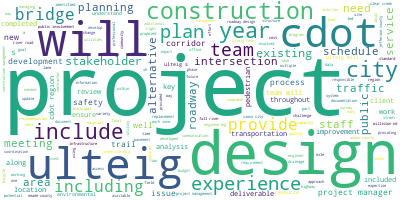

In [4]:
from wordcloud import WordCloud

# Join texts
long_string = ','.join(list(df['text_processed'].values))

# Generate a word cloud
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

# LDA

In [5]:
import gensim
from gensim.utils import simple_preprocess
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['design', 'project', 'ulteig', 'team', 'projects', 'nd'])    # Note - add or remove misc. stopwords here

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df.text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
#print("some example text data:", data_words[:1][0][:30])

C:\Users\helen.schawe\AppData\Roaming\Python\Python38\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [6]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [7]:
import gensim

# User input: number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=1)

'''
# Print the Keyword in the topics
from pprint import pprint
pprint(lda_model.print_topics())
'''

'\n# Print the Keyword in the topics\nfrom pprint import pprint\npprint(lda_model.print_topics())\n'

## Visualization

In [8]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_' + str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.004573  0.001302       1        1  31.395445
0      0.004634 -0.002673       2        1  30.002945
4      0.003244  0.001918       3        1  24.089902
2     -0.003604 -0.003148       4        1  10.464073
3      0.000299  0.002600       5        1   4.047636, topic_info=             Term        Freq       Total Category  logprob  loglift
119          cdot  655.000000  655.000000  Default  30.0000  30.0000
177  construction  530.000000  530.000000  Default  29.0000  29.0000
201        county  421.000000  421.000000  Default  28.0000  28.0000
602          plan  404.000000  404.000000  Default  27.0000  27.0000
134          city  456.000000  456.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
584            pe    6.697758  161.614807   Topic5  -6.0109   0.0236
653       quality    8.215378  259.032328   Topic5  -5.8067  -0.2439
603      planning    7.744101  241.134346   Topic5  -5.8658  -0.2314
920          work    7.828910  262.406407   Topic5  -5.8549  -0.3050
643       provide    7.076120  216.363915   Topic5  -5.9560  -0.2132

[455 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4054      1  0.173870  abdullah
4054      2  0.434675  abdullah
4054      3  0.260805  abdullah
4054      4  0.086935  abdullah
4054      5  0.043468  abdullah
...     ...       ...       ...
2858      1  0.373156      zone
2858      2  0.233223      zone
2858      3  0.209901      zone
2858      4  0.139934      zone
2858      5  0.046645      zone

[1256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 3, 4])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


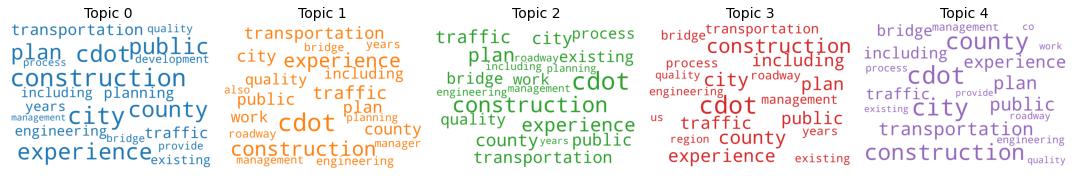

In [21]:
# Wordcloud of LDA, top 10 words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

topics = lda_model.show_topics(num_topics=5, num_words=20, formatted=False)

# Note - change first 2 numbers (row, cols) when changing num. of topics
fig, axes = plt.subplots(1, 5, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud = WordCloud(stopwords=stop_words, background_color='white', width=2500, height=1800, max_words=20, colormap='tab10', \
                      color_func=lambda *args, **kwargs: cols[i], prefer_horizontal=1.0)
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=14))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# NMF - better for texts w similar topics

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# TF IDF
texts = df['text_processed']
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)
tfidf = tfidf_vectorizer.fit_transform(texts)
tfidf.toarray()

# NMF - Input: change n_components to desired number of topics
nmf_model = NMF(n_components=5)
nmf_model.fit(tfidf)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


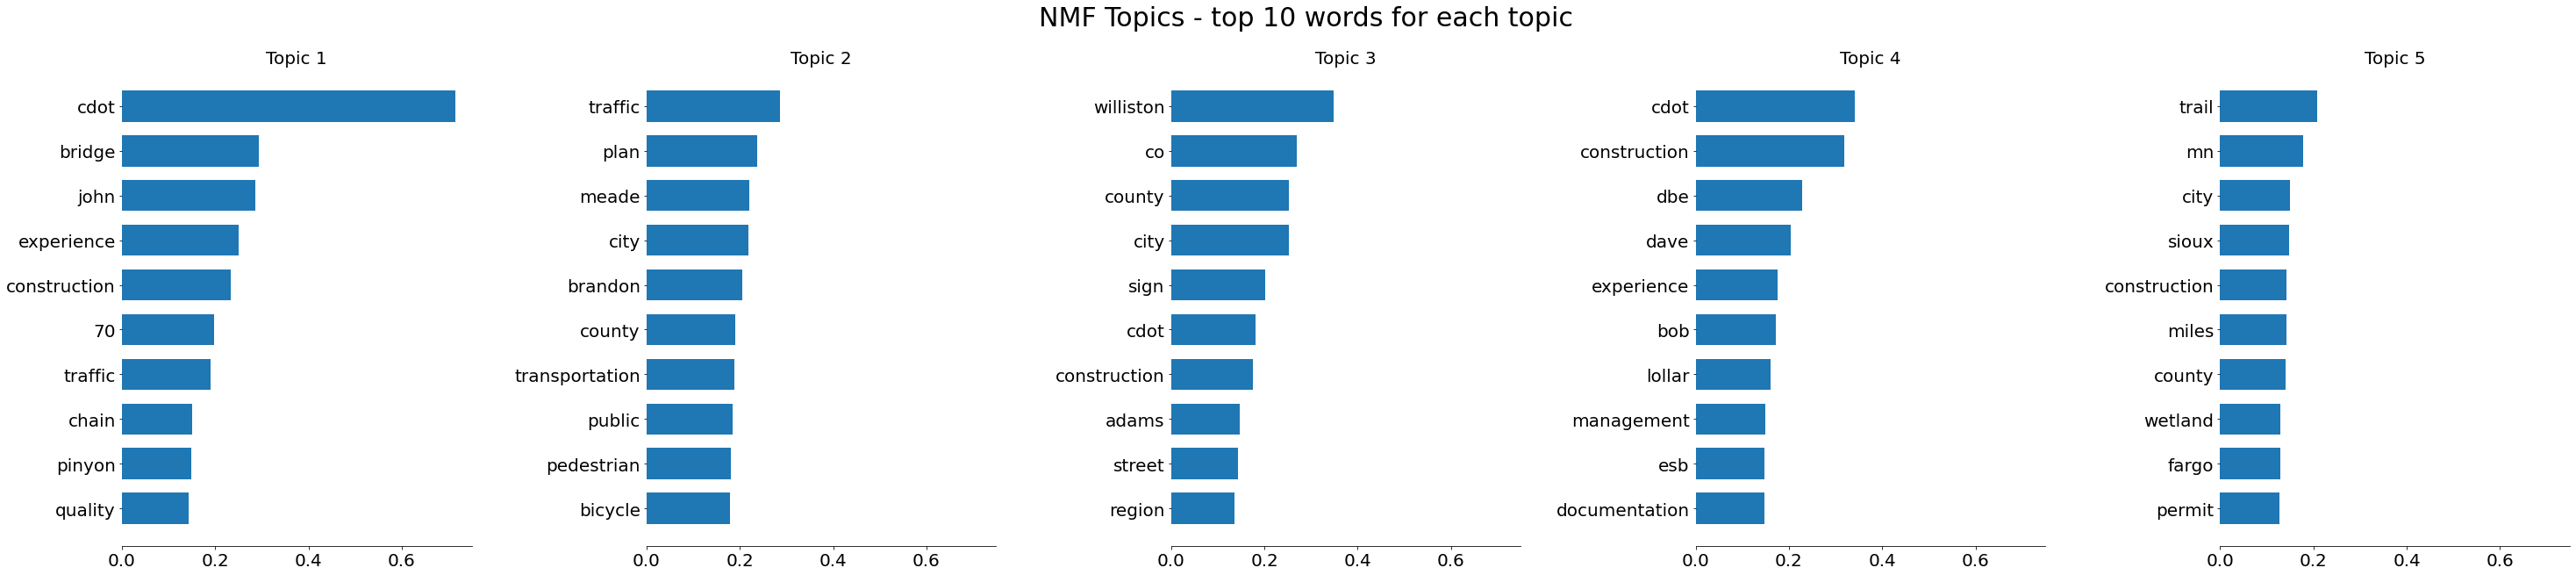

In [37]:
# User inputs: # of words to display, and major title
n_top_words = 10
title = "NMF Topics - top " + str(n_top_words) + " words for each topic"

# plot top 10 words for each topic
feature_names = tfidf_vectorizer.get_feature_names()
fig, axes = plt.subplots(1, 5, figsize=(50, 10), sharex=True)    # Note - change (rows, cols) to match num. topics
axes = axes.flatten()
for topic_idx, topic in enumerate(nmf_model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',
                 fontdict={'fontsize': 20})
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=20)
    for i in 'top right left'.split():
        ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=30)

plt.subplots_adjust(wspace=0.50)
plt.show()